# Control predictivo

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import scipy as sc
from scipy.signal import lfilter


## Predictor a $d$-pasos

In [115]:
def calcularPolinomiosPredictivo(A,Bp,d):
    # Calculo de polinomios del predictor
    F = lfilter([1], A, np.r_[1, np.zeros(d-1)])
    Gp = np.r_[1,np.zeros(len(A)+d-2)] - np.polymul(A,F) 
    G = Gp[d:]
    FBp = np.polymul(F,Bp)

    print("F =", F)
    print("G =", G)  
    print(f'Prueba ec Diofantina: AF+q^(-d)G ={np.polymul(A,F)+np.r_[np.zeros(d),G]}')
    return F,G,FBp

F = [1.   1.5  1.55]
G = [ 1.275 -1.085]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0. 0.]


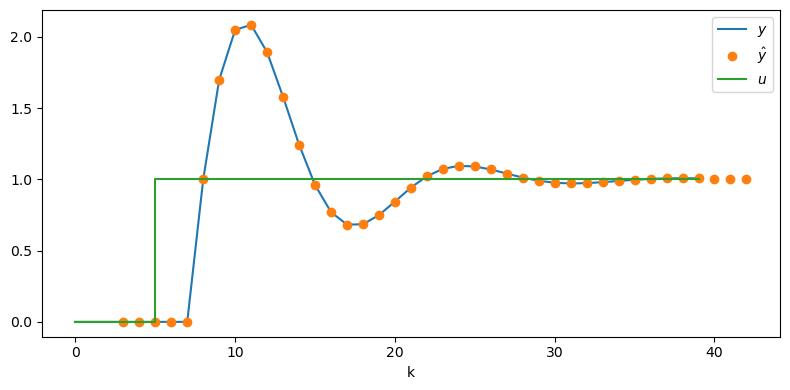

In [121]:
# Modelo de la planta
A = np.r_[1,-1.5,0.7]
Bp = np.r_[1,-0.8]
d = 3

F, G, FBp = calcularPolinomiosPredictivo(A,Bp,d)

N = 40
k = np.arange(0,N)
u = np.zeros(N)
u[5:] = 1
#u = np.sin(np.pi*2*k/10)

# Desplazo la entrada para simular el efecto del retardo
u_d = np.zeros_like(u)
u_d[d:] = u[:-d]

# Calculo la salida de la planta (simulación)
y = lfilter(Bp, A, u_d)

# Calculo la predicción a d pasos
Gy    = lfilter(G, [1], y)
FBpu  = lfilter(FBp, [1], u)
y_hat = np.zeros_like(y)
y_hat = Gy + FBpu

# Plot
plt.figure(figsize=(8,4))
plt.plot(k, y, label='$y$')
plt.plot(k+d, y_hat,'o', markevery=1, label='$\hat{y}$')
plt.step(k, u, label='$u$',where='post')
plt.legend()
plt.xlabel('k')
#plt.grid()
plt.tight_layout()
plt.show()


## Simulación del control predictivo

F = [1.   1.74]
G = [ 2.2576 -1.3398]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0.]


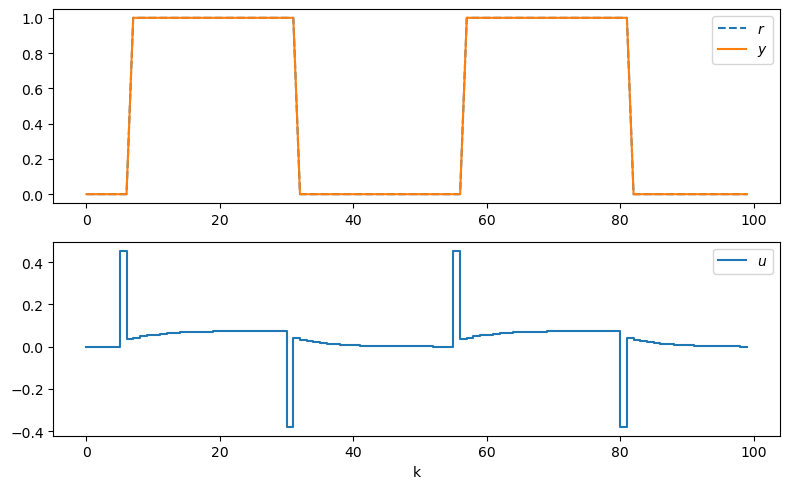

In [131]:
def simularControlPredictivo(A,Bp,d,r,plot=True,title=None,deltaA=None,deltaB=None):
    F,G,FBp = calcularPolinomiosPredictivo(A,Bp,d)

    if deltaA is not None:
        A *= (1+deltaA)
    if deltaB is not None:
        Bp *= (1+deltaB)

    # señales
    N = len(r)
    k = np.arange(N)
    u = np.zeros(N)
    y = np.zeros(N)

    for kk in range(d+1,N-d):

        # ===== Control predictivo =====
        # y_hat_d = G*y + FB' * u  (pero evaluado en k)
        Gy     = np.dot(G, y[kk:kk-len(G):-1]) 
        FBpu   = np.dot(FBp[1:], u[kk-1:kk-len(FBp):-1]) 
        # ecuación óptima: FB' u_k = r_{k+d} - Gy
        u[kk] = (r[kk+d] - Gy - FBpu)/FBp[0]

        # ===== Simulación de la Planta =====
        # parte autoregresiva de la salida
        y_AR = np.dot(-A[1:],y[kk:kk-len(A)+1:-1])    
        # parte que depende de la entrada retrasada
        y_X = np.dot(Bp, u[kk-d+1:kk-d+1-len(Bp):-1])
        # salida total
        y[kk+1] = y_AR + y_X


    # ===========================================
    # Graficos
    # ===========================================
    if plot:
        plt.figure(figsize=(8,5))
        plt.subplot(211)
        plt.plot(k, r, '--', label='$r$')#,where='post')
        plt.plot(k, y, label='$y$')
        if title is not None:
            plt.title(title)
        plt.legend()
        plt.subplot(212)
        plt.step(k, u, label='$u$',where='post')
        plt.legend()
        plt.xlabel("k")
        plt.tight_layout()
        plt.show()

    return y,u

A = np.r_[1, -1.74, .77]
Bp = 2 * np.r_[1.1, -.9]
d = 2

k = np.arange(100)
r = 0.5 * (sc.signal.square(2*np.pi * k / 50 - np.pi/4) + 1)

_,_ = simularControlPredictivo(A,Bp,d,r)

F = [1.   1.74]
G = [ 2.2576 -1.3398]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0.]


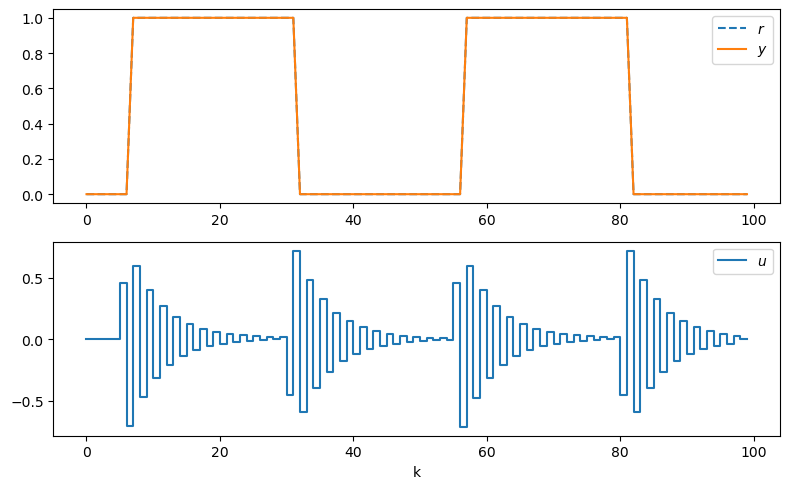

F = [1.   1.74]
G = [ 2.2576 -1.3398]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0.]


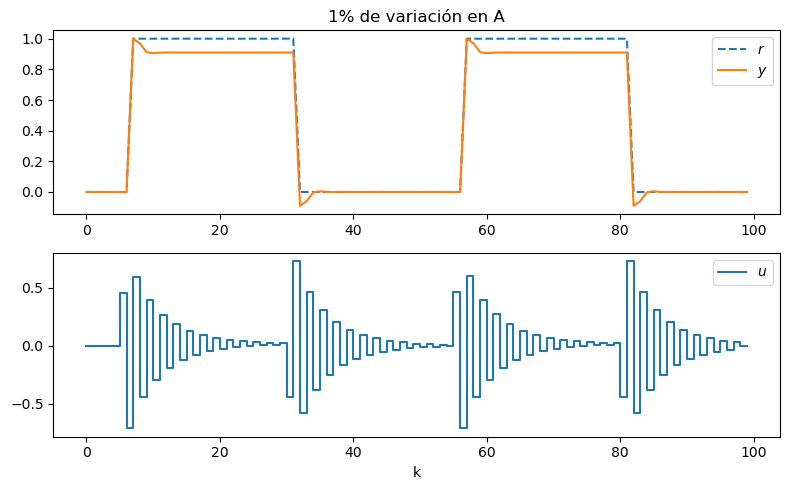

F = [1.       1.709724]
G = [ 2.14722716 -1.32662443]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0.]


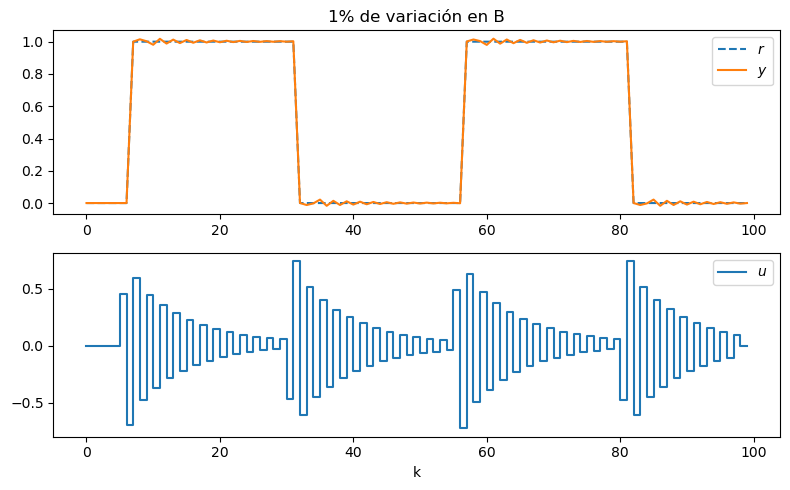

In [134]:
# Cambiamos la planta para que tenga un cero en -0.9
A = np.r_[1, -1.74, .77]
Bp = 2 * np.r_[1.1, .9]
d = 2

y,u = simularControlPredictivo(A,Bp,d,r)

deltaA = np.r_[0, -1.74/100, .77/100]
y,u = simularControlPredictivo(A,Bp,d,r,deltaA=deltaA,title='1% de variación en A')

deltaB = 2 * np.r_[0, .9/100]
y,u = simularControlPredictivo(A,Bp,d,r,deltaB=deltaB,title='1% de variación en B')


F = [1.   1.5  1.55]
G = [ 1.275 -1.085]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0. 0.]


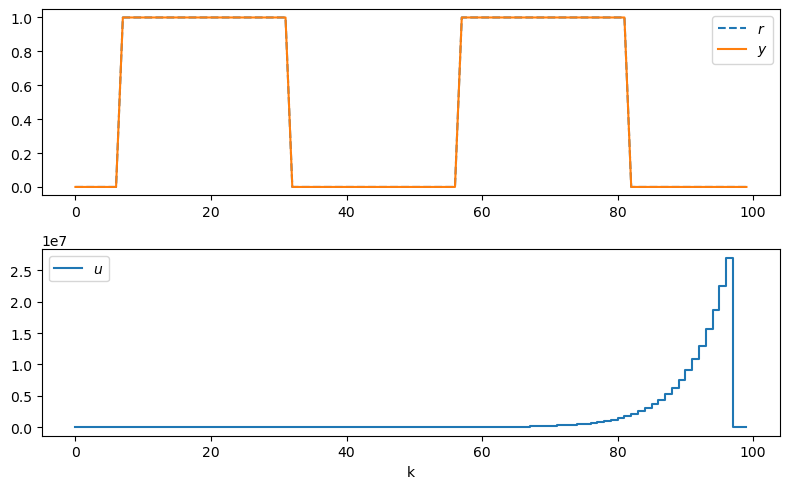

In [135]:
# Veamos que pasa con una planta de fase no mínima
_,_ = simularControlPredictivo(np.r_[1,-1.5,0.7],np.r_[1,-1.2],3,r)

## Control predictivo ponderado

F = [1.   1.74]
G = [ 2.2576 -1.3398]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0.]
F = [1.   1.74]
G = [ 2.2576 -1.3398]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0.]
F = [1.   1.74]
G = [ 2.2576 -1.3398]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0.]
F = [1.   1.74]
G = [ 2.2576 -1.3398]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0.]


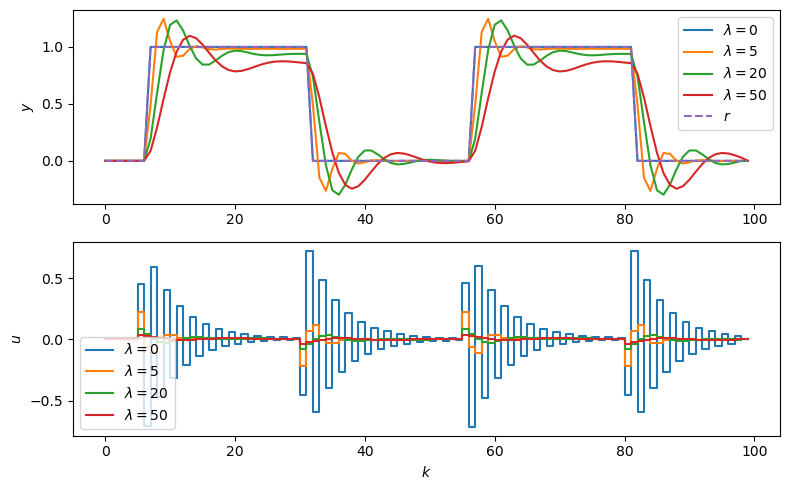

In [162]:
def simularControlPredictivoPonderado(A,Bp,d,r,lambda_=0,plot=True,deltaA=None,deltaB=None):
    F,G,FBp = calcularPolinomiosPredictivo(A,Bp,d)

    A_ = A; Bp_ = Bp
    if deltaA is not None:
        A_ = A.copy() * (1+deltaA)
    if deltaB is not None:
        Bp_ = Bp.copy() * (1+deltaB)
    

    # señales
    N = len(r)
    k = np.arange(N)
    u = np.zeros(N)
    y = np.zeros(N)

    for kk in range(d+len(Bp),N-d):

        # ===== Control predictivo =====
        # y_hat_d = G*y + FB' * u  (pero evaluado en k)
        #Gy = np.sum(G[1:] * y[kk-np.arange(1,len(Ap))])
        #FBpu = np.sum(FBp[1:] * u[kk-np.arange(1,len(FBp))])

        Gy     = np.dot(G, y[kk:kk-len(G):-1]) 
        FBpu   = np.dot(FBp[1:], u[kk-1:kk-len(FBp):-1]) 
        # ecuación óptima: FB' u_k = r_{k+d} - Gy
        u[kk] = (r[kk+d] - Gy - FBpu)/ (Bp[0]+lambda_/Bp[0])

        # ===== Simulación de la Planta =====
        # parte autoregresiva de la salida
        y_AR = np.dot(-A_[1:],y[kk:kk-len(A_)+1:-1])    
        # parte que depende de la entrada retrasada
        y_X = np.dot(Bp_, u[kk-d+1:kk-d+1-len(Bp_):-1])
        # salida total
        y[kk+1] = y_AR + y_X


    # ===========================================
    # Graficos
    # ===========================================
    if plot:
        plt.figure(figsize=(8,5))
        plt.subplot(211)
        plt.step(k, r, '--', label='$r$',where='post')
        plt.plot(k, y, label='$y$')
        plt.legend()
        plt.subplot(212)
        plt.step(k, u, label='$u$',where='post')
        plt.legend()
        plt.xlabel("k")
        plt.tight_layout()
        plt.show()

    return y,u


A = np.r_[1, -1.74, .77]
Bp = 2 * np.r_[1.1, .9]
d = 2

k = np.arange(100)
r = 0.5 * (sc.signal.square(2*np.pi * k / 50 - np.pi/4) + 1)

plt.figure(figsize=(8,5))
for lambda_ in [0,5,20,50]:
    y,u = simularControlPredictivoPonderado(A,Bp,d,r,lambda_=lambda_,plot=False)
    plt.subplot(211)
    plt.plot(k, y, label=f'$\lambda=${lambda_}')
    plt.subplot(212)
    plt.step(k, u, label=f'$\lambda=${lambda_}',where='post')
    
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$u$')
plt.subplot(211)
plt.plot(k, r, '--', label='$r$')
plt.ylabel('$y$')
plt.legend()
plt.tight_layout()
plt.show()


## Efecto de las incertidumbres en el control predictivo ponderado

F = [1.   1.74]
G = [ 2.2576 -1.3398]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0.]
F = [1.   1.74]
G = [ 2.2576 -1.3398]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0.]
F = [1.   1.74]
G = [ 2.2576 -1.3398]
Prueba ec Diofantina: AF+q^(-d)G =[1. 0. 0. 0.]


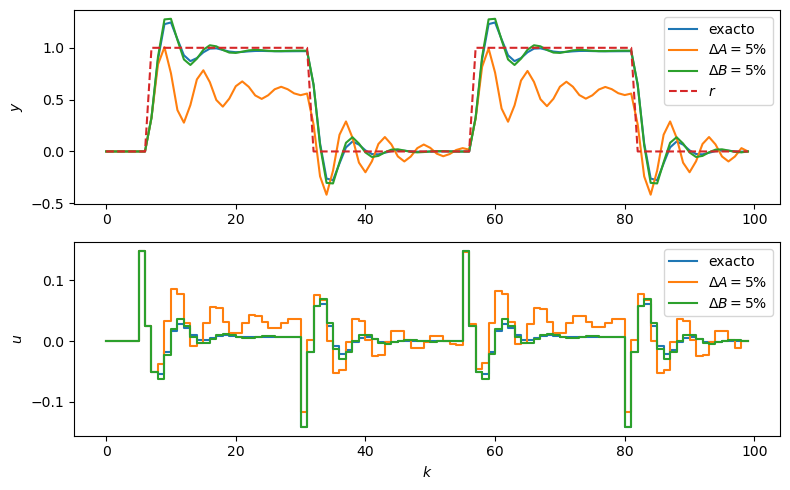

In [163]:
A = np.r_[1, -1.74, .77]
Bp = 2 * np.r_[1.1, .9]
d = 2

y,u = simularControlPredictivoPonderado(A,Bp,d,r,lambda_=10,plot=False)

dA = 5
deltaA = np.r_[0, -1.74*dA/100.0, .77*dA/100.0]
ya,ua = simularControlPredictivoPonderado(A,Bp,d,r,lambda_=10,plot=False,deltaA=deltaA)

dB = 5
deltaB = 2 * np.r_[0, .9*dB/100.0]
yb,ub = simularControlPredictivoPonderado(A,Bp,d,r,lambda_=10,plot=False,deltaB=deltaB)

plt.figure(figsize=(8,5))
plt.subplot(211)
plt.plot(k, y, label=f'exacto')
plt.plot(k, ya, label=f'$\Delta A ={dA}\%$')
plt.plot(k, yb, label=f'$\Delta B ={dB}\%$')
plt.plot(k, r, '--', label='$r$')
plt.ylabel('$y$')
plt.legend()

plt.subplot(212)
plt.step(k, u, label=f'exacto',where='post')
plt.step(k, ua, label=f'$\Delta A ={dA}\%$',where='post')
plt.step(k, ub, label=f'$\Delta B ={dB}\%$',where='post')
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$u$')
plt.tight_layout()
plt.show()
